In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from src import soporte_abtesting as sa


In [4]:
df = pd.read_csv('marketing_AB.csv')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB


In [19]:
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
# Check if the categorical variables have appropriate number of levels
df_cat = df[['test group', 'converted', 'most ads day', 'most ads hour']]
df_cat.nunique()

test group        2
converted         2
most ads day      7
most ads hour    24
dtype: int64

In [22]:
df.describe()

,user id,total ads,most ads hour
count,5.881010e+05,588101.000000,588101.000000
mean,1.310692e+06,24.820876,14.469061
std,2.022260e+05,43.715181,4.834634
min,9.000000e+05,1.000000,0.000000
25%,1.143190e+06,4.000000,11.000000
50%,1.313725e+06,13.000000,14.000000
75%,1.484088e+06,27.000000,18.000000
max,1.654483e+06,2065.000000,23.000000


- Hay una gran dispersión de los datos en total ads

In [25]:
df['test group'].value_counts()

test group
ad     564577
psa     23524
Name: count, dtype: int64

- La muestra para el grupo de control (psa) y el grupo test (ad)  esta desbalanceada

In [27]:
df['most ads day'].value_counts()

most ads day
Friday       92608
Monday       87073
Sunday       85391
Thursday     82982
Saturday     81660
Wednesday    80908
Tuesday      77479
Name: count, dtype: int64

In [29]:
# Agrupa por 'test group' y cuenta los valores de 'converted'
converted_by_group = df.groupby('test group')['converted'].value_counts()

# Muestra el resultado
print(converted_by_group)

test group  converted
ad          False        550154
            True          14423
psa         False         23104
            True            420
Name: count, dtype: int64


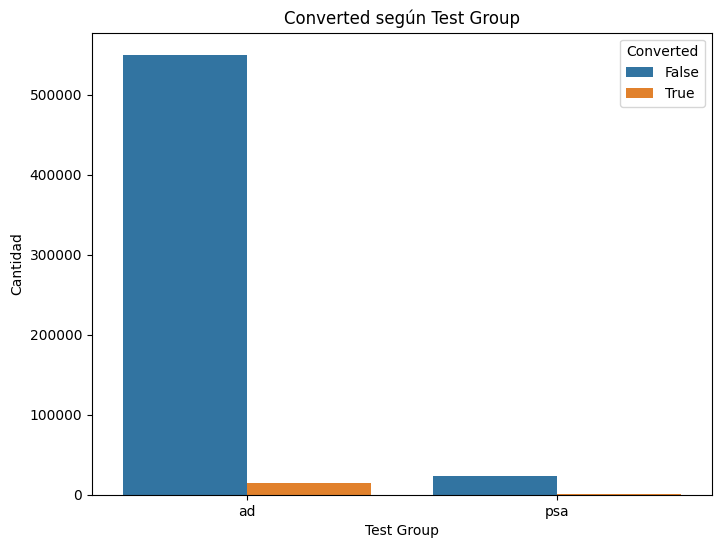

In [30]:
# Agrupa por 'test group' y 'converted' y cuenta los valores
converted_by_group = df.groupby(['test group', 'converted']).size().reset_index(name='count')

# Crea el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(data=converted_by_group, x='test group', y='count', hue='converted')

# Personaliza el gráfico
plt.title('Converted según Test Group')
plt.xlabel('Test Group')
plt.ylabel('Cantidad')
plt.legend(title='Converted')
plt.show()

## Interpretación del Problema

    - Desequilibrio en los grupos: ad (564,577 usuarios) vs psa (23,524 usuarios).
        - Esto implica que solo ~4% de los usuarios están en el grupo de control (psa), lo cual es un desbalanceo extremo.
        - Riesgo: El A/B testing podría estar sesgado porque el grupo ad domina los resultados estadísticos.

    - Outliers en total_ads: Algunos usuarios están expuestos a muchos más anuncios que otros (ej. 72 vs 2).
        - Riesgo: La exposición desigual a anuncios puede confundir el efecto real del tratamiento (ad vs psa).



### Step 1: Balanceo de la muestra para resolver el problema estructural.

In [41]:
ad_sample = df[df['test group'] == 'ad'].sample(n=23524, random_state=42)
balanced_df = pd.concat([ad_sample, df[df['test group'] == 'psa']])
balanced_df['test group'].value_counts()

test group
ad     23524
psa    23524
Name: count, dtype: int64

In [42]:
balanced_df.to_csv('balanced_data.csv', index=False)

## Outlier Detection
Ahora que tenemos una muestra balanceada (balanced_df), el siguiente paso es identificar y manejar outliers. La columna más importante para analizar es total_ads (número total de anuncios vistos por usuario), ya que:

    - Es una variable numérica continua.

    - Tiene una gran dispersión..

    - Puede afectar directamente a la métrica de conversión (converted).

In [13]:
def filter_outliers(data, whisker=1.5):
    """
    Identifies outliers in a dataset using the IQR method.

    Parameters:
        data (pd.Series): A pandas Series containing numerical data.
        whisker (float): The multiplier for the interquartile range (IQR). Default is 1.5.

    Returns:
        pd.Series: A boolean Series where True indicates an outlier.
    """
    # Calculate the first and third quartiles
    Q1 = data.quantile(0.25)  # 25th percentile
    Q3 = data.quantile(0.75)  # 75th percentile

    # Compute the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for non-outliers
    lower_bound = Q1 - whisker * IQR
    upper_bound = Q3 + whisker * IQR

    # Identify outliers
    is_outlier = data[(data < lower_bound) | (data > upper_bound)]

    return is_outlier

In [43]:
outliers = filter_outliers(balanced_df['total ads'])
print(f"Total number of outliers : {len(outliers)}")
print(f"Total number of recors   : {len(df)}")
print(f"Percentage of outliers   : {len(outliers)/len(df)*100:.2f}%")

Total number of outliers : 4286
Total number of recors   : 588101
Percentage of outliers   : 0.73%


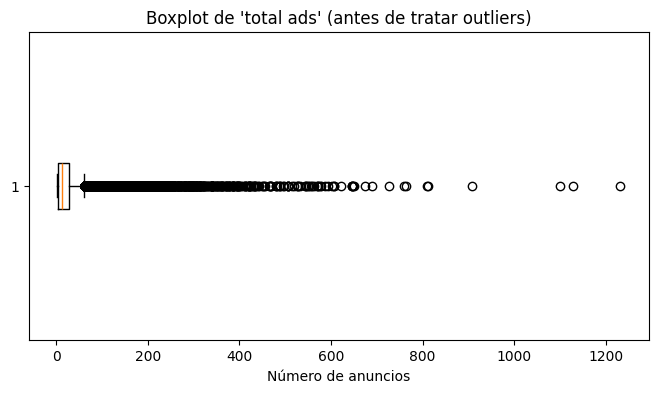

In [45]:
# Boxplot de 'total_ads'
plt.figure(figsize=(8, 4))
plt.boxplot(balanced_df['total ads'], vert=False)
plt.title("Boxplot de 'total ads' (antes de tratar outliers)")
plt.xlabel("Número de anuncios")
plt.show()

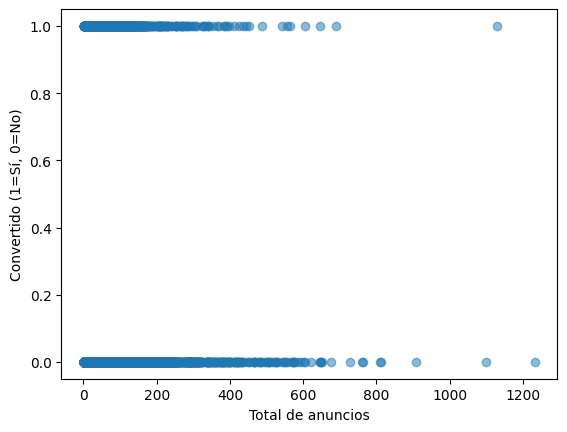

In [47]:
## relacion de outlyers con converted 
plt.scatter(balanced_df['total ads'], balanced_df['converted'], alpha=0.5)
plt.xlabel('Total de anuncios')
plt.ylabel('Convertido (1=Sí, 0=No)')
plt.show()

In [49]:
## están los outlyers concentrados en un grupo ?
outliers_group = balanced_df[balanced_df['total ads'].isin(outliers)]['test group'].value_counts()
print(outliers_group)

test group
psa    2196
ad     2090
Name: count, dtype: int64


In [58]:
# Separate the dataframe into two groups
outliers_balanced_df = balanced_df[balanced_df.index.isin(outliers.index)]
no_outliers_balanced_df = balanced_df[~balanced_df.index.isin(outliers.index)]

# Calculate avg seen ads with/without outliers
mean_ads_overall = balanced_df['total ads'].mean()
mean_ads_without_outliers = no_outliers_balanced_df['total ads'].mean()
print(f"Overall average ads seen : {mean_ads_overall:.2f} ads")
print(f"Without outliers average ads seen : {mean_ads_without_outliers:.2f} ads")

# Calculate conversion rate with/without outliers
conversion_overall = (balanced_df['converted'] == True).mean() * 100
conversion_without_outliers = (no_outliers_balanced_df['converted'] == True).mean() * 100
print(f'Overal conversion rate: {conversion_overall:.2f}%')
print(f'Without outliers conversion rate: {conversion_without_outliers:.2f}%')

Overall average ads seen : 24.75 ads
Without outliers average ads seen : 14.81 ads
Overal conversion rate: 2.25%
Without outliers conversion rate: 1.22%


C:\Users\marta\AppData\Local\Temp\ipykernel_3980\2391666502.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ads_df, x='Category', y='Average Ads Seen', palette='Blues')
C:\Users\marta\AppData\Local\Temp\ipykernel_3980\2391666502.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conversion_df, x='Category', y='Conversion Rate (%)', palette='Greens')


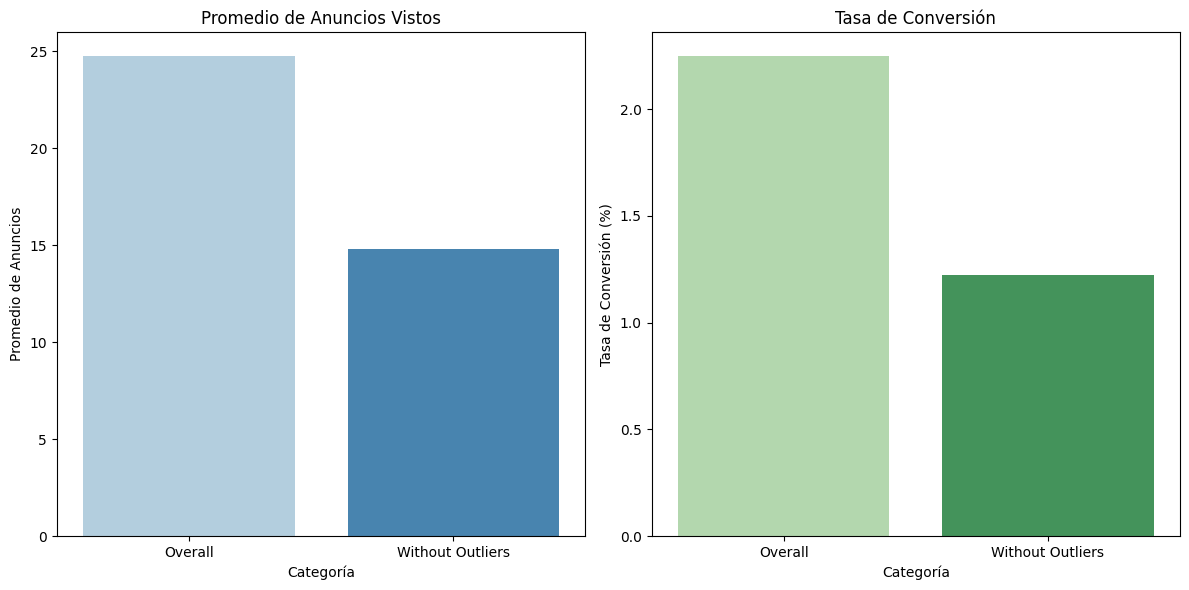

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Datos para los promedios de anuncios vistos
ads_data = {
    'Category': ['Overall', 'Without Outliers'],
    'Average Ads Seen': [mean_ads_overall, mean_ads_without_outliers]
}

# Datos para las tasas de conversión
conversion_data = {
    'Category': ['Overall', 'Without Outliers'],
    'Conversion Rate (%)': [conversion_overall, conversion_without_outliers]
}

# Crear DataFrames para visualización
ads_df = pd.DataFrame(ads_data)
conversion_df = pd.DataFrame(conversion_data)

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Gráfico de barras para los promedios de anuncios vistos
plt.subplot(1, 2, 1)
sns.barplot(data=ads_df, x='Category', y='Average Ads Seen', palette='Blues')
plt.title('Promedio de Anuncios Vistos')
plt.ylabel('Promedio de Anuncios')
plt.xlabel('Categoría')

# Gráfico de barras para las tasas de conversión
plt.subplot(1, 2, 2)
sns.barplot(data=conversion_df, x='Category', y='Conversion Rate (%)', palette='Greens')
plt.title('Tasa de Conversión')
plt.ylabel('Tasa de Conversión (%)')
plt.xlabel('Categoría')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

### **Gráfico 1: Promedio de Anuncios Vistos**
- **Eje X (Categoría):** Muestra dos categorías: 
  - `Overall` (con todos los datos, incluidos los outliers).
  - `Without Outliers` (sin los outliers).
- **Eje Y (Promedio de Anuncios):** Representa el promedio de anuncios vistos en cada categoría.

### **1. Comparación de Promedios**
Promedio general de anuncios vistos (con outliers): 24.75
Promedio sin outliers: 14.81

Los outliers (valores extremadamente altos en total_ads) están inflando el promedio general.
La diferencia es enorme: +67% (24.75 vs 14.81). Esto confirma que los outliers tienen un impacto significativo en la métrica.

### **2. Tasa de Conversión**
Tasa de conversión general (con outliers): 2.25%

Tasa de conversión sin outliers: 1.22%

Los outliers están sobreestimando la conversión real en un 84% (2.25% vs 1.22%).

Esto sugiere que los usuarios con exposición extrema a anuncios (total_ads muy altos) están convirtiendo mucho más que el promedio, lo que distorsiona los resultados.

## Análisis de Causas

- Usuarios hiperactivos: Algunos usuarios (ej. bots, empleados, o usuarios obsesivos) están expuestos a una cantidad anormal de anuncios y convierten más.

- Esto podría ser un sesgo de selección: ¿Estos outliers son representativos de tu población real?

- Causalidad inversa: ¿Los usuarios convierten porque ven muchos anuncios? ¿O ven muchos anuncios porque ya están interesados (y por eso convierten más)?

## Definir Hipótesis

Hipótesis nula (H₀): No hay diferencia en la tasa de conversión entre ad y psa.

Hipótesis alternativa (H₁): El grupo ad tiene una tasa de conversión mayor.

## Análisis sin outliers

,mean,std
test group,,
ad,0.0138,0.1167
psa,0.0106,0.1024


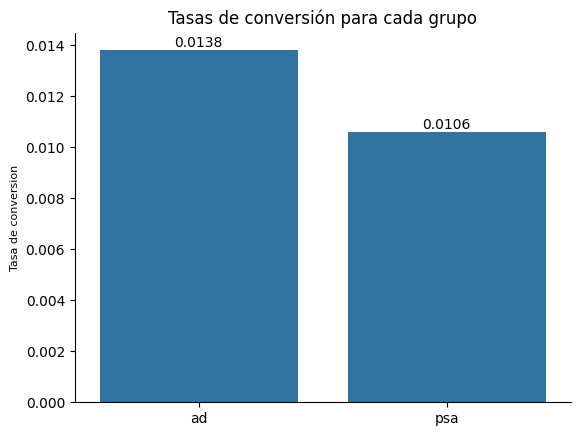

In [ ]:
ratio_conversion = no_outliers_balanced_df.groupby('test group')['converted'].agg(["mean", "std"]).round(4)
display(ratio_conversion)

fig = sns.barplot(ratio_conversion, 
                  x = ratio_conversion.index, 
                  y = "mean") 

# ponemos las etiquetas en cada una de las barras
fig.bar_label(fig.containers[0], fontsize=10)

# eliminar los ejes de arriba y la derecha
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)

# ponemos título a la gráfica
fig.set_title("Tasas de conversión para cada grupo")

# cambiamos el nombre del eje y
fig.set_ylabel("Tasa de conversion", fontsize = 8)

# quitamos el nombre del eje x
fig.set_xlabel("");


In [71]:
# Tasa de conversión por grupo
conversion_rates = no_outliers_balanced_df.groupby('test group')['converted'].mean()
print(conversion_rates)

# Diferencia absoluta y relativa
diff = conversion_rates['ad'] - conversion_rates['psa']
rel_diff = diff / conversion_rates['psa']
print(f"Diferencia absoluta: {diff:.4f}, Relativa: {rel_diff:.2%}")

test group
ad     0.013810
psa    0.010596
Name: converted, dtype: float64
Diferencia absoluta: 0.0032, Relativa: 30.33%


### Prueba Estadística

Test de proporciones (Chi-cuadrado o Z-test)
Ideal para comparar tasas de conversión binarias.

In [74]:
# Preparar datos
from statsmodels.stats.proportion import proportions_ztest
counts = no_outliers_balanced_df.groupby('test group')['converted'].sum()
nobs = no_outliers_balanced_df['test group'].value_counts()

# Ejecutar test
z_stat, p_value = proportions_ztest(counts, nobs)
print(f"p-value: {p_value:.4f}")

p-value: 0.0025


# Análisis con los outliers

## Tasa de conversión

,mean,std
test group,,
ad,0.1632,0.3696
psa,0.0883,0.2839


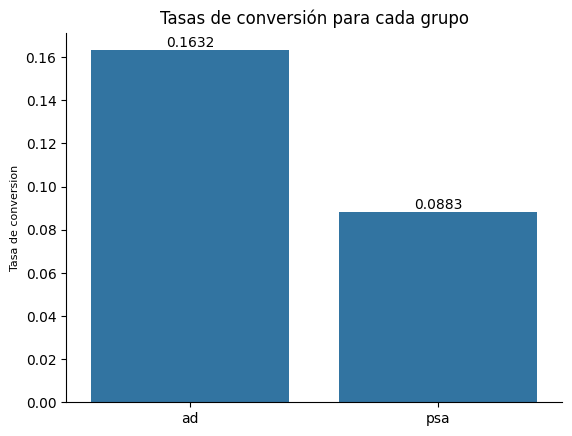

In [93]:
ratio_conversion2 = outliers_balanced_df.groupby('test group')['converted'].agg(["mean", "std"]).round(4)
display(ratio_conversion)

fig = sns.barplot(ratio_conversion2, 
                  x = ratio_conversion2.index, 
                  y = "mean") 

# ponemos las etiquetas en cada una de las barras
fig.bar_label(fig.containers[0], fontsize=10)

# eliminar los ejes de arriba y la derecha
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)

# ponemos título a la gráfica
fig.set_title("Tasas de conversión para cada grupo")

# cambiamos el nombre del eje y
fig.set_ylabel("Tasa de conversion", fontsize = 8)

# quitamos el nombre del eje x
fig.set_xlabel("");

In [84]:
# Tasa de conversión por grupo
conversion_rates_outliers = outliers_balanced_df.groupby('test group')['converted'].mean()
print(conversion_rates_outliers)

# Diferencia absoluta y relativa
diff = conversion_rates_outliers['ad'] - conversion_rates_outliers['psa']
rel_diff = diff / conversion_rates_outliers['psa']
print(f"Diferencia absoluta: {diff:.4f}, Relativa: {rel_diff:.2%}")

test group
ad     0.163158
psa    0.088342
Name: converted, dtype: float64
Diferencia absoluta: 0.0748, Relativa: 84.69%


In [92]:
no_outliers_balanced_df['test group'].value_counts()

test group
ad     21434
psa    21328
Name: count, dtype: int64

In [88]:
balanced_df['test group'].value_counts()

test group
ad     23524
psa    23524
Name: count, dtype: int64

In [89]:
outliers_balanced_df['test group'].value_counts()

test group
psa    2196
ad     2090
Name: count, dtype: int64

## Prubea estadística con outliers

In [85]:
counts_out = outliers_balanced_df.groupby('test group')['converted'].sum()
nobs_out = outliers_balanced_df['test group'].value_counts()

# Ejecutar test
z_stat, p_value = proportions_ztest(counts_out, nobs_out)
print(f"p-value: {p_value:.4f}")

p-value: 0.0000


# Conclusiones
- Tanto con outliers comosin ellos se muestra una diferencia significativa en la captación de clientes en el grupo de testing, por lo que la campaña funciona.

# Tamaño muestral sin outliers


In [94]:
import statsmodels.stats.proportion as sms
import math
from statsmodels.stats.power import NormalIndPower
import statsmodels.stats.api as sms

# Tasas de conversión observadas en tus datos (sin outliers)
p1 = 0.010596  # Grupo psa (control)
p2 = 0.0138  # Grupo ad (tratamiento). Ajusta según lo que esperas.

# 1. Calcula el tamaño del efecto (diferencia estandarizada)
diferencia = sms.proportion_effectsize(p1, p2)  

# 2. Calcula el tamaño muestral requerido
tamaño_muestral = sms.NormalIndPower().solve_power(
    diferencia,
    power=0.8,    # Potencia deseada (80%)
    alpha=0.05,   # Nivel de significancia (5%)
    ratio=1       # Mismo tamaño para ambos grupos
)

print(f'Tamaño muestral necesario por grupo: {math.ceil(tamaño_muestral)}')

Tamaño muestral necesario por grupo: 18346


El tamaño muestral requerido es mayor que tu dataset actual:

Opción 1: Recolectar más datos.

Opción 2: Ajustar expectativas (ej. aceptar un efecto más pequeño o menor potencia).

# Tamaño muestral de los outliers

In [95]:
# Tasas de conversión observadas en tus datos (con outliers)
p1 = 0.08834  # Grupo psa (control)
p2 = 0.163158  # Grupo ad (tratamiento). Ajusta según lo que esperas.

# 1. Calcula el tamaño del efecto (diferencia estandarizada)
diferencia = sms.proportion_effectsize(p1, p2)  

# 2. Calcula el tamaño muestral requerido
tamaño_muestral = sms.NormalIndPower().solve_power(
    diferencia,
    power=0.8,    # Potencia deseada (80%)
    alpha=0.05,   # Nivel de significancia (5%)
    ratio=1       # Mismo tamaño para ambos grupos
)

print(f'Tamaño muestral necesario por grupo: {math.ceil(tamaño_muestral)}')

Tamaño muestral necesario por grupo: 302
